## Install packages

In [26]:
!conda install matplotlib -n pmill -y
!conda install -c intel scikit-learn -n pmill -y

//anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

//anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,
Solving environment: done


==> WARNING: A newer version of conda exists

## Imports

In [1]:
from dask.distributed import Client, progress

import dask
import dask.dataframe as dd

import pandas as pd

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which 
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [2]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

//anaconda/envs/pmill/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62460 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:62461 Dashboard: http://127.0.0.1:62460/status,Cluster Workers: 2 Cores: 4 Memory: 2.00 GB


## Create Random Dataframe

In [3]:
df = dask.datasets.timeseries()

Unlike Pandas, Dask DataFrames are lazy and so no data is printed here.

In [4]:
df

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


In [9]:
df.shape

(Delayed('int-96c91d81-764e-4e89-9c74-17731df24e91'), 4)

But the column names and dtypes are known.

In [5]:
df.dtypes

id        int64
name     object
x       float64
y       float64
dtype: object

Some operations will automatically display the data.

In [6]:
pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [7]:
df.head(3)

,id,name,x,y
timestamp,,,,
2000-01-01 00:00:00,960,Ingrid,-0.55,0.63
2000-01-01 00:00:01,1038,Kevin,0.18,0.70
2000-01-01 00:00:02,973,Yvonne,-0.39,0.33


## Use Standard Pandas Operations

Most common Pandas operations operate identically on Dask dataframes

In [10]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 157 tasks

## Compute

Call `.compute()` when you want your result as a Pandas dataframe.

In [11]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [12]:
computed_df

name
Alice      0.58
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.58
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.57
Name: x, Length: 26, dtype: float64

## Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [13]:
df = df.persist()

## Time Series Operations

Because we have a datetime index time-series operations work efficiently

In [14]:
%matplotlib inline

In [15]:
df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,-7.05e-03,1.18e-02
2000-01-01 01:00:00,1.04e-02,7.92e-03
2000-01-01 02:00:00,1.90e-03,1.08e-02
2000-01-01 03:00:00,-8.82e-03,-2.45e-03
2000-01-01 04:00:00,-1.37e-02,6.17e-04


<AxesSubplot:xlabel='timestamp'>

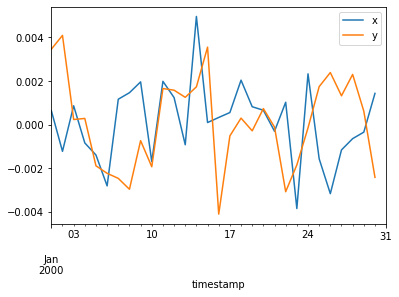

In [16]:
df[['x', 'y']].resample('24h').mean().compute().plot()

In [17]:
df[['x', 'y']].rolling(window='24h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,-0.55,0.63
2000-01-01 00:00:01,-0.19,0.66
2000-01-01 00:00:02,-0.26,0.55
2000-01-01 00:00:03,-0.09,0.24
2000-01-01 00:00:04,0.09,0.27


Random access is cheap along the index, but must still be computed.

In [18]:
df.loc['2000-01-05']

,id,name,x,y
npartitions=1,,,,
2000-01-05 00:00:00.000000000,int64,object,float64,float64
2000-01-05 23:59:59.999999999,...,...,...,...


In [19]:
%time df.loc['2000-01-05'].compute()

CPU times: user 33.5 ms, sys: 14.2 ms, total: 47.7 ms
Wall time: 153 ms


,id,name,x,y
timestamp,,,,
2000-01-05 00:00:00,1048,Oliver,-0.29,-1.28e-01
2000-01-05 00:00:01,997,Edith,-0.30,-1.88e-02
2000-01-05 00:00:02,1013,Ursula,-0.38,8.57e-02
2000-01-05 00:00:03,970,Sarah,0.95,7.99e-01
2000-01-05 00:00:04,1005,Dan,-0.56,5.85e-01
...,...,...,...,...
2000-01-05 23:59:55,952,Sarah,0.01,9.87e-01
2000-01-05 23:59:56,1029,Jerry,0.51,4.78e-03
2000-01-05 23:59:57,986,Quinn,-0.34,-4.18e-01


## Set Index

Data is sorted by the index column.  This allows for faster access, joins, groupby-apply operations, etc..  However sorting data can be costly to do in parallel, so setting the index is both important to do, but only infrequently.

In [20]:
df = df.set_index('name')
df

,id,x,y
npartitions=30,,,
Alice,int64,float64,float64
Alice,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Because computing this dataset is expensive and we can fit it in our available RAM, we persist the dataset to memory.

In [21]:
df = df.persist()

Dask now knows where all data lives, indexed cleanly by name.  As a result oerations like random access are cheap and efficient

In [22]:
%time df.loc['Alice'].compute()

CPU times: user 51.6 ms, sys: 12.3 ms, total: 63.9 ms
Wall time: 163 ms


,id,x,y
name,,,
Alice,994,-0.25,0.81
Alice,994,-0.47,-0.74
Alice,994,0.42,0.77
Alice,1038,-0.28,0.34
Alice,1004,0.23,-0.74
...,...,...,...
Alice,1022,-0.23,0.19
Alice,1022,-0.50,-0.48
Alice,1084,-0.05,0.78


## Groupby Apply with Scikit-Learn

Now that our data is sorted by name we can easily do operations like random access on name, or groupby-apply with custom functions.

Here we train a different Scikit-Learn linear regression model on each name.

In [23]:
from sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)
    return est

In [24]:
df.groupby('name').apply(train, meta=object).compute()

name
Alice      LinearRegression(copy_X=True, fit_intercept=Tr...
Bob        LinearRegression(copy_X=True, fit_intercept=Tr...
Charlie    LinearRegression(copy_X=True, fit_intercept=Tr...
Dan        LinearRegression(copy_X=True, fit_intercept=Tr...
Edith      LinearRegression(copy_X=True, fit_intercept=Tr...
                                 ...                        
Victor     LinearRegression(copy_X=True, fit_intercept=Tr...
Wendy      LinearRegression(copy_X=True, fit_intercept=Tr...
Xavier     LinearRegression(copy_X=True, fit_intercept=Tr...
Yvonne     LinearRegression(copy_X=True, fit_intercept=Tr...
Zelda      LinearRegression(copy_X=True, fit_intercept=Tr...
Length: 26, dtype: object

In [28]:
a = df.shape
a[0].compute(),a[1]

(2592000, 3)

## Further Reading

For a more in-depth introduction to Dask dataframes, see the [dask tutorial](https://github.com/dask/dask-tutorial), notebooks 04 and 07.